# NN surrogate for Braking Distance Estimation
## Model Training, Proof of Monotonicity & Stability Assessment

This tutorial illustrates the steps of training a surrogate model, defining input ranges, verifying monotonicity, computing upper bounds and checking stability on a case study of braking distance estimation.

## Introduction
In the realm of modern transportation, functions that predict accurate estimation of braking distance are crucial to ensure safety as they may play a pivotal role in e.g. preventing accidents. As neural networks are increasingly becoming a prevalent solution, it is essential to verify their performance and robustness in order to maintain high safety standards.

This tutorial presents a comprehensive approach to verifying braking distance estimation predicted by neural networks by mean of a verification pipeline that integrates multiple verification techniques aimed to ensure NN accuracy and reliability.

<div>
<img src="braking_distance_estimation_images/safe_surrogate.png" width="300"/>
</div>

## Why Verification Matters

Verification is the process of ensuring via guarantees that a system will behave as expected under various conditions. In the context of neural networks used for braking distance estimation, verification is vital because of:

- Reliability: Verification ensures that the neural network performs consistently across different scenarios.

- Compliance: Regulatory standards require rigorous verification of all components involved in safety-critical systems.

## Getting Started

This notebook assumes that the user has:

- a basic understanding of neural networks and machine learning concepts

- some familiarity with Python programming

- an access to the required software tools and dataset

## Case Study: Braking Distance Estimation

The [Cessna 172 Skyhawk](https://en.wikipedia.org/wiki/Cessna_172) is a renowned American aircraft, known for its four-seat capacity, single-engine design, and high-wing, fixed-wing configuration. Manufactured by the Cessna Aircraft Company, the Skyhawk holds the title of the most successful aircraft in history, thanks to its remarkable longevity and widespread popularity. Since the delivery of the first production model in 1956, over 44,000 units had been built by 2015, a testament to its enduring appeal and reliability. The Cessna 172 continues to be produced today, maintaining its status as a staple in aviation.

### Environment
- If you run this notebook on Colab, install the following dependencies.
- If you run this notebook locally, install dependencies using the provided pyproject.toml / requirements.txt file.

In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln
    pass

### Data & Models

We will evaluate the safety of a simple braking distance estimation model where predictions are solely derived from information on pressure altitude and temperature.

Download: The simulation code is available here as [cesna_simulation.py](https://github.com/ducoffeM/safety_braking_distance_estimation/blob/main/cesna_simulation.py) and should be stored in a subdirectory safety_braking_distance_estimation.

In [2]:
#!git clone https://github.com/ducoffeM/safety_braking_distance_estimation.git

## Import

In [57]:
import os
import pickle
import time
from typing import Tuple
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
###
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact
import tensorflow as tf
from keras.layers import Activation, Dense
from keras.models import Sequential
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [4]:
import safety_braking_distance_estimation
from safety_braking_distance_estimation.cesna_simulation import cesna_landing

In [5]:
from verif_pipeline import (StabilityProperty,
                            compute_bounds,
                            StatusVerif, ProblemContainer,
                            BoundsDomainBoxParameter, BoundsDomainBoxParameterPerValueInterval,
                            full_verification_pipeline)
from csv_exporter.global_output_to_csv import dump_csv
from blocks_hub.gml_mip_block import GMLBrick
from blocks_hub.decomon_block import DecomonBlock
from blocks_hub.adv_block import CleverhansAdvBlock

Could not import GroupSort or GroupSort2 from deel.lip.activations. Please install deel-lip for being compatible with 1 Lipschitz network (see https://github.com/deel-ai/deel-lip)
Could not import GroupSort or GroupSort2 from deel.lip.activations. Please install deel-lip for being compatible with 1 Lipschitz network (see https://github.com/deel-ai/deel-lip)


In [6]:
import logging
all_logs=False
if all_logs:
    logging.basicConfig(level=logging.INFO)
else:
    logging.basicConfig(level=logging.WARNING)

## STEP 1: Train a model to predict the braking distance estimation

### Input Ranges

We here assume the following ranges for the model inputs:

Temperature: 0°C to 40°C \
Pressure altitude: 0 feet to 4000 feet

In [7]:
MIN_temp = 0  # celsius
MAX_temp = 40

MIN_alt = 0
MAX_alt = 4000

### Data Generation

In [8]:
def generate_dataset(N, MIN=[MIN_temp, MIN_alt], MAX=[MAX_temp, MAX_alt]):
    alpha_temp = np.array([np.random.rand() for _ in range(N)])
    alpha_alt = np.array([np.random.rand() for _ in range(N)])

    X = np.zeros((N, 2))
    X[:, 0] = alpha_temp * MIN[0] + (1 - alpha_temp) * MAX[0]
    X[:, 1] = alpha_alt * MIN[1] + (1 - alpha_alt) * MAX[1]

    Y = [cesna_landing(X[i, 0], X[i, 1]) for i in range(N)]

    return X, np.array(Y)  # samples, associated landing distance

In [9]:
# Generate training, validation and test dataset

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(1000)
X_test, y_test = generate_dataset(5000)

In [10]:
# Normalize using mean and variance of the train dataset

MEAN_x = np.mean(X_train, 0)[None]
STD_x = np.std(X_train, 0)[None]

print(MEAN_x)
print(STD_x)

X_train_ = (X_train - MEAN_x) / STD_x
X_valid_ = (X_valid - MEAN_x) / STD_x
X_test_ = (X_test - MEAN_x) / STD_x

MEAN_y = np.mean(y_train, 0)
STD_y = np.std(y_train, 0)

y_train_ = (y_train - MEAN_y) / STD_y
y_valid_ = (y_valid - MEAN_y) / STD_y
y_test_ = (y_test - MEAN_y) / STD_y

[[  19.94741022 2008.30827626]]
[[  11.57898216 1165.87015909]]


### Model definition, training and evaluation

In [11]:
layers = [Dense(20, input_dim=2,activation="relu"), Dense(20,activation="relu"), Dense(1)]
model = Sequential(layers)
model.compile("adam", "mse")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 501 (1.96 KB)
Trainable params: 501 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the neural network on the normalised dataset

In [13]:
model.fit(X_train_, y_train_, batch_size=32, epochs=10, validation_data=(X_valid_, y_valid_))

Epoch 1/10
313/313 [==============================] - 0s 622us/step - loss: 0.0911 - val_loss: 0.0021
Epoch 2/10
313/313 [==============================] - 0s 348us/step - loss: 0.0012 - val_loss: 4.1557e-04
Epoch 3/10
313/313 [==============================] - 0s 362us/step - loss: 3.1568e-04 - val_loss: 2.4786e-04
Epoch 4/10
313/313 [==============================] - 0s 441us/step - loss: 2.2267e-04 - val_loss: 1.9277e-04
Epoch 5/10
313/313 [==============================] - 0s 342us/step - loss: 1.7874e-04 - val_loss: 1.5757e-04
Epoch 6/10
313/313 [==============================] - 0s 339us/step - loss: 1.4345e-04 - val_loss: 1.1566e-04
Epoch 7/10
313/313 [==============================] - 0s 342us/step - loss: 1.0887e-04 - val_loss: 9.1248e-05
Epoch 8/10
313/313 [==============================] - 0s 364us/step - loss: 9.6011e-05 - val_loss: 8.3042e-05
Epoch 9/10
313/313 [==============================] - 0s 351us/step - loss: 8.5011e-05 - val_loss: 7.5857e-05
Epoch 10/10
313/313 [=

In [14]:
# Model evaluation

y_pred_test = model.predict(X_test_)
model.evaluate(X_test_, y_test_)

157/157 [==============================] - 0s 238us/step - loss: 7.2849e-05


7.284915773198009e-05

In [15]:
# Define (and normalise) inputs bounds

MIN_temp_=(MIN_temp-MEAN_x[0][0])/STD_x[0][0]
MAX_temp_=(MAX_temp-MEAN_x[0][0])/STD_x[0][0]
MIN_alt_=(MIN_alt-MEAN_x[0][1])/STD_x[0][1]
MAX_alt_=(MAX_alt-MEAN_x[0][1])/STD_x[0][1]

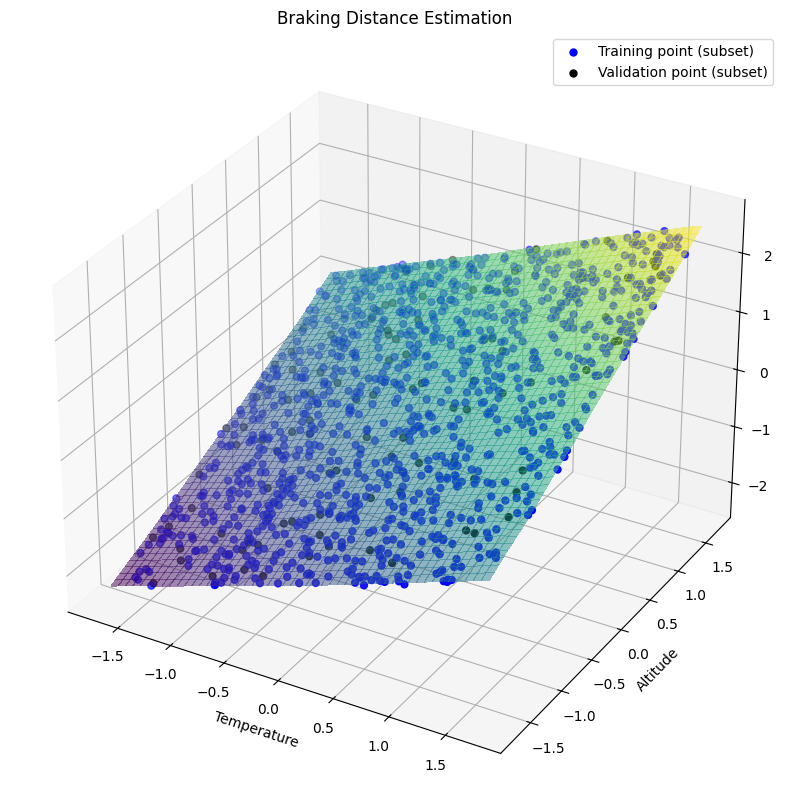

In [16]:
def plot_3d(xt, yt, xtest, ytest, fun, name_figure = "Braking Distance Estimation"):
    
    x_temp = np.linspace(MIN_temp_, MAX_temp_, 50)
    x_alt = np.linspace(MIN_alt_, MAX_alt_, 50)
    res = []
    for x0 in x_temp:
        for x1 in x_alt:
            res.append(fun(np.array([[x0, x1]])))
    res = np.array(res)
    res = res.reshape((50, 50)).T
    X, Y = np.meshgrid(x_temp, x_alt)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(X, Y, res, cmap=matplotlib.colormaps["viridis"],
                           linewidth=0, antialiased=False, alpha=0.5)
    
    if xt is not None:
        ax.scatter(xt[:, 0], xt[:, 1], yt, zdir='z', marker='.', c='b', s=100, label='Training point (subset)')
    if xtest is not None:
        ax.scatter(xtest[:, 0], xtest[:, 1], ytest, zdir='z', marker='.', c='k', s=100, label='Validation point (subset)')

    ax.set_title(name_figure)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Altitude')
    ax.legend()

plot_3d(X_train_[:1000], y_train_[:1000], X_valid_[:100], y_valid_[:100], model)

### Quick empirical check on model monotonicity

According to the principles of physics, the braking distance should increase with both temperature and altitude i.e., there is a monotonic relationship between the input variables and the braking distance. We check that increasing input values (both for temperature and altitude) results in increasing braking distance for a few set of increasing inputs.

In [17]:
def check_monotonicity(test):
    predicted_braking_distances = model.predict(test)
    print("Predicted Braking Distances for test inputs:")
    for i, dist in enumerate(predicted_braking_distances):
        print(f"Input {test[i]}: {dist}")
    is_monotonic = np.all(np.diff(predicted_braking_distances) >= 0)
    if is_monotonic:
        print("Monotonicity: True")
    else:
        print("Monotonicity: False")

In [18]:
test_inputs = np.array([
    [0, 0],
    [MAX_temp_ / 2, MAX_alt_ / 2],
    [MAX_temp_, MAX_alt_]])
check_monotonicity(test_inputs)

1/1 [==============================] - 0s 8ms/step
Predicted Braking Distances for test inputs:
Input [0. 0.]: [-0.04109099]
Input [0.86590468 0.85416532]: [1.2559392]
Input [1.73180937 1.70833065]: [2.5467157]
Monotonicity: True


In [19]:
test_inputs = np.array([
    [0, MAX_alt_ /2],
    [MAX_temp_ / 5, MAX_alt_ /2],
    [2 * MAX_temp_ / 5, MAX_alt_ /2],
    [3 * MAX_temp_ / 5, MAX_alt_ /2],
    [4 * MAX_temp_ / 5, MAX_alt_ /2],
    [MAX_temp_, MAX_alt_ /2]])
check_monotonicity(test_inputs)

1/1 [==============================] - 0s 7ms/step
Predicted Braking Distances for test inputs:
Input [0.         0.85416532]: [0.63493794]
Input [0.34636187 0.85416532]: [0.8757717]
Input [0.69272375 0.85416532]: [1.1289598]
Input [1.03908562 0.85416532]: [1.3801006]
Input [1.38544749 0.85416532]: [1.6166854]
Input [1.73180937 0.85416532]: [1.8548626]
Monotonicity: True


In [20]:
test_inputs = np.array([
    [MAX_temp_ / 2, 0],
    [MAX_temp_ / 2, MAX_alt_ / 5],
    [MAX_temp_ / 2, 2 * MAX_alt_ / 5],
    [MAX_temp_ / 2, 3 * MAX_alt_ / 5],
    [MAX_temp_ / 2, 4 * MAX_alt_ / 5],
    [MAX_temp_ / 2, MAX_alt_]])
check_monotonicity(test_inputs)

1/1 [==============================] - 0s 8ms/step
Predicted Braking Distances for test inputs:
Input [0.86590468 0.        ]: [0.5690757]
Input [0.86590468 0.34166613]: [0.84567493]
Input [0.86590468 0.68333226]: [1.1250602]
Input [0.86590468 1.02499839]: [1.3895351]
Input [0.86590468 1.36666452]: [1.6613859]
Input [0.86590468 1.70833065]: [1.932117]
Monotonicity: True


## STEP2: Guaranteeing model over estimation using the AIROBAS verification pipeline

In a case of braking distance estimation, an under- or over-prediction of a surrogate compared to its original reference model can lead to a very different security risk. See e.g., the following illustration.

<div>
<img src="braking_distance_estimation_images/overestimate-braking-distance-estimation.png" width="300"/>
</div>

A number of situations can occur during the landing phase of an aircraft. 

- If the braking distance is shorter than the remaining runway, the aircraft is in a safe zone. If the surrogate model predicts this braking distance (or smaller), the aircraft would perform a safe landing. If the surrogate model predicts a braking distance that is higher, the aircraft may decide to proceed to an (unnecessary) turn around ... not a safety-critical situation per sé but airlines may not see these unnecessary manoeuvres favorably (e.g., operating cost increase etc.)

- If the braking distance is longer than the remaining runway, the aircraft is in a danger zone. If the surrogate predicts this braking distance or higher, the aircraft will receive the necessary warning to turn around. If the surrogate predicts a braking distance that is smaller, the aircraft will receive the information that it is safe to land but will in fact over run the runway ... which of course, presents a hugh safety risk.

It is therefore crucial to ensure that not only the surrogate model is highly performant, but also that its predictions are always overestimating the reference model.

Let's verify this property.


In the rest of the analysis, we will assume that the surrogate model predictions respect monotonicity i.e., that for x1 < x2, f(x1) < f(x2). 

In [21]:
# Compute the minimum and maximum values for inputs (temperature and altitude) perturbed by a given "noise" epsilon
 
def compute_input_bounds(x: np.ndarray,
                         epsilon_tmp: float = 0.1,
                         epsilon_alt: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the lower and upper bounds for the input parameters.

    Parameters:
    x (np.ndarray): Input array containing temperature and altitude values.
    epsilon_tmp (float): Perturbation factor for temperature.
    epsilon_alt (float): Perturbation factor for altitude.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the lower bound and upper bound arrays.
    """
    
    # Create an epsilon array with perturbation factors for temperature and altitude
    epsilon = np.array([epsilon_tmp, epsilon_alt])[None]
    
    # Compute the lower and upper bound by subtracting/adding epsilon from x
    lower_bound_input = x - epsilon
    upper_bound_input = x + epsilon
    
    return lower_bound_input, upper_bound_input

In [22]:
# Compute maximum value of the braking distance from the maximum values of the perturbed inputs
# To be compared to the lower bound derived from the surrogate model

def compute_cesna_bounds(x: np.array, 
                         epsilon_tmp: float = 0.1,
                         epsilon_alt: float = 0.1,
                         std_y: float = STD_y,
                         mean_y: float = MEAN_y) -> np.ndarray:
    """
    Compute the maximum value for the braking distance given input parameters
    and their perturbations.

    Parameters:
    x (np.array): Input array containing temperature and altitude values.
    epsilon_tmp (float): Perturbation factor for temperature.
    epsilon_alt (float): Perturbation factor for altitude.
    std_y (float): Standard deviation used for normalizing the model's output.
    mean_y (float): Mean used for normalizing the model's output.

    Returns:
    np.ndarray: The normalized upper bound braking distances for the perturbed inputs.
    """
    
    # Compute the maximum bounds for the input parameters based on perturbations
    x_max = compute_input_bounds(x, epsilon_tmp, epsilon_alt)[1]#return lower and upper bound 
    
    # Predict the braking distances for the perturbed inputs using the Cesna landing model
    y_min = np.array([cesna_landing(x_max[i, 0], x_max[i, 1]) for i in range(x.shape[0])])
    
    # Normalize the output values: (output - mean_y)/std_y
    y_min_norm = (y_min - mean_y) / std_y
    
    # Return the normalized maximum value of braking distance
    return y_min_norm[:, None]  # ,np.inf * np.ones_like(y_min) - Note: Uncomment if additional bounds are needed

In [23]:
# Compute the "allowed" bounds for the braking distance prediction i.e., [ymin,inf]

def compute_output_bounds(y_min: np.array) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the output bounds for the braking distance estimation model.

    Parameters:
    y_min (np.array): The minimum predicted braking distances (lower bound).

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the lower bound (y_min)
    and the upper bound (set to infinity for each corresponding element in y_min).
    """
    
    # The lower bound is given by y_min
    lower_bound = y_min
    
    # The upper bound is set to infinity for each element in y_min
    upper_bound = np.inf * np.ones_like(y_min)
    
    # Return the lower and upper bounds as a tuple
    return lower_bound, upper_bound

### Verification pipeline

Initialisation

In [24]:
# Import components from verification pipeline module
from verif_pipeline import (
    BoundsDomainParameter,
    ProblemContainer,
    full_verification_pipeline,
)

In [25]:
# Initialize the input bound domain parameter
input_bound_domain_param = BoundsDomainParameter()

# Assign function to compute min and mx values of the input parameters
input_bound_domain_param.compute_lb_ub_bounds = compute_input_bounds

In [26]:
# Initialize output bound domain parameter
output_bound_domain_param = BoundsDomainParameter()

# Assign function to compute the lower and upper bounds for the output values
output_bound_domain_param.compute_lb_ub_bounds = compute_output_bounds

Stability Property - Definition

In [27]:
property = StabilityProperty(
    input_bound_domain_param=input_bound_domain_param,
    output_bound_domain_param=output_bound_domain_param
)

Problem Container --- that encapsulates the problem definition, including a unique identifier (tag_id), the trained model (model), and the stability property

In [28]:
# Create a problem container to encapsulate the problem definition
problem = ProblemContainer(
    tag_id=1,  # Unique identifier for the problem instance
    model=model,  # The trained model to be verified
    stability_property=property  # The stability property to be verified
)

Verification Blocks:

- Block 1: CleverhansAdvBlock: used for adversarial attack verification, with specific parameters for targeting, attack direction, and method.
- Block 2: DecomonBlock: used for incomplete verification.
- Block 3: GMLBrick: used for computing bounds with options for warm start and complete verification.

In [29]:
blocks = [
    (CleverhansAdvBlock, {"index_target": 0, "attack_up": False, "fgs": True}), 
    # CleverhansAdvBlock is used for adversarial attack verification
    # index_target=0: only one class is targeted
    # attack_up=False: checking for overestimation
    # fgs=True: using Fast Gradient Sign method for generating adversarial examples
    
    (DecomonBlock, {}), 
    # DecomonBlock is used for decompositional verification
    
    (GMLBrick, {"do_bounds_computation": True, "do_warm_start": True})
    # GMLBrick is used for computing bounds with the options to warm start
]

### Verification & Analysis

Execute the full_verification_pipeline function with the defined problem, input points, output points, and blocks.

In [30]:
# Compute the braking distance of the X_test dataset using the Cesna model
output_cesna = compute_cesna_bounds(X_test) #for cesna model

In [31]:
# Run the full verification pipeline with the defined problem, input points, output points, and blocks
global_verif=full_verification_pipeline(
    problem=problem,
    input_points=X_test_,#normalized inputs
    output_points=output_cesna,
    blocks_verifier=blocks,
    verbose=False  # Enable verbose output for detailed logging
)

In [32]:
from verif_pipeline import StatusVerif
print("Summary of global verification:")
print(np.sum(global_verif.status==StatusVerif.VERIFIED), "Verified points")
print(np.sum(global_verif.status==StatusVerif.VIOLATED), "Violated points")
print(np.sum(global_verif.status==StatusVerif.TIMEOUT), "Timeout points")
print(np.sum(global_verif.status==StatusVerif.UNKNOWN), "Unknown points")

Summary of global verification:
0 Verified points
5000 Violated points
0 Timeout points
0 Unknown points


In [33]:
methods = np.array(global_verif.methods)
index_that_concluded = global_verif.index_block_that_concluded
methods_concluded = methods[index_that_concluded]

# Count the unique values and their counts
unique_values, counts = np.unique(methods_concluded, return_counts=True)

print(f"The method(s) {unique_values} concluded on {counts} Points")

The method(s) ['CleverhansAdvBlock'] concluded on [5000] Points


### Correct model predictions using a shift

We see in this first verification phase that the surrogate model will often underestimate the braking distance estimation provided by cesna, thus violating the set safety requirement. In order to minimize or avoid such violation and guarantee safeness, one can apply a (hopefully small) shift to the model prediction. 

The advantage of such "shift" and optimal derivation of its value has been introduced in Ducoffe et al. 2020 (see [here](https://ceur-ws.org/Vol-2560/paper11.pdf)).

We will start by applying a small shift that would provide examples of both "safe" and "unsafe" test points.

In [34]:
def shift_model(model:keras.Model,
                shift: float=0):
    bias = (model.layers[-1].bias).numpy()
    return model.layers[-1].bias.assign(bias + shift)


In [35]:
shift_model(model=model,shift=0.14)

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.10463054], dtype=float32)>

In [36]:
global_verif=full_verification_pipeline(
    problem=problem,
    input_points=X_test_,#normalized inputs
    output_points=output_cesna,
    blocks_verifier=blocks,
    verbose=True)  # Enable verbose output for detailed logging

from verif_pipeline import StatusVerif
print("Summary of global verification:")
print(np.sum(global_verif.status==StatusVerif.VERIFIED), "Verified points")
print(np.sum(global_verif.status==StatusVerif.VIOLATED), "Violated points")
print(np.sum(global_verif.status==StatusVerif.TIMEOUT), "Timeout points")
print(np.sum(global_verif.status==StatusVerif.UNKNOWN), "Unknown points")

methods = np.array(global_verif.methods)
index_that_concluded = global_verif.index_block_that_concluded
methods_concluded = methods[index_that_concluded]
unique_values, counts = np.unique(methods_concluded, return_counts=True)

print(f"The method(s) {unique_values} concluded respectively on {counts} Points")

58/58 [==============================] - 0s 772us/step
Restricted license - for non-production use only - expires 2025-11-24
Summary of global verification:
1848 Verified points
3152 Violated points
0 Timeout points
0 Unknown points
The method(s) ['CleverhansAdvBlock' 'DecomonBlock' 'GMLBrick'] concluded respectively on [3152 1292  556] Points


We see that the shift makes the model systematically overestimate the braking distance with more points assessed as "verified".

### Robustness to higher "noise"

Let's increase the input noise (epsilon 0.1 >> 0.4)

In [37]:
output_cesna = compute_cesna_bounds(X_test, epsilon_tmp = 0.4,epsilon_alt = 0.4)
global_verif=full_verification_pipeline(
    problem=problem,
    input_points=X_test_,#normalized inputs
    output_points=output_cesna,
    blocks_verifier=blocks,
    verbose=True)  # Enable verbose output for detailed logging

from verif_pipeline import StatusVerif
print("Summary of global verification:")
print(np.sum(global_verif.status==StatusVerif.VERIFIED), "Verified points")
print(np.sum(global_verif.status==StatusVerif.VIOLATED), "Violated points")
print(np.sum(global_verif.status==StatusVerif.TIMEOUT), "Timeout points")
print(np.sum(global_verif.status==StatusVerif.UNKNOWN), "Unknown points")

methods = np.array(global_verif.methods)
index_that_concluded = global_verif.index_block_that_concluded
methods_concluded = methods[index_that_concluded]
unique_values, counts = np.unique(methods_concluded, return_counts=True)

print(f"The method(s) {unique_values} concluded respectively on {counts} Points")

11/11 [==============================] - 0s 918us/step
Summary of global verification:
325 Verified points
4675 Violated points
0 Timeout points
0 Unknown points
The method(s) ['CleverhansAdvBlock' 'DecomonBlock' 'GMLBrick'] concluded respectively on [4675  169  156] Points


We see that a higher input noise worsens the model safety assessment (i.e., increase the number of "violated" test points).

## Visualisation of results

In [54]:
def formal_verif_2D(epsilon_tmp,epsilon_alt, grid_alt=1, grid_temp=1):
    n_1D_alt = grid_alt  # number of split along the 'altitude' dimension
    n_1D_temp = grid_temp  # number of split along the 'temperature' dimension
   
    # sample for bounding
    alt = np.linspace(MIN_alt, MAX_alt, n_1D_alt)
    temp = np.linspace(MIN_temp, MAX_temp, n_1D_temp)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xticks(alt)
    ax.set_xticklabels(np.floor(alt), rotation=40)
    ax.set_yticks(temp)
    count_unsafe = 0
    error_formal = []

    for i, alt_i in enumerate(alt):#[:-1]):
        for j, temp_j in enumerate(temp):#[:-1]):

            #d_x_i = alt[i + 1] - alt[i]
            #d_y_j = temp[j + 1] - temp[j]

            #x_max_i = alt[i + 1]
            #x_max_j = temp[j + 1]
            #_, y_max_ij = generate_dataset(1, MIN=[x_max_i, x_max_j], MAX=[x_max_i, x_max_j])
            
            x_tmp = np.array([[temp[j], alt[i]]])
            output_cesna = compute_cesna_bounds(x_tmp,epsilon_tmp=epsilon_tmp,epsilon_alt=epsilon_alt)
            x_tmp = (x_tmp - MEAN_x) / STD_x

            # Run the full verification pipeline with the defined problem, input points, output points, and blocks
            global_verif=full_verification_pipeline(
                problem=problem,
                input_points=x_tmp,
                output_points=output_cesna,
                blocks_verifier=blocks,
                verbose=False  # Enable verbose output for detailed logging
            )
 
            if np.sum(global_verif.status==StatusVerif.VERIFIED)>0:
                color = "green"

            else:
                error_formal.append(i)#index of non-robust points
                count_unsafe = 1
                color = "orange"

            #rect = patches.Rectangle((alt_i, temp_j), d_x_i, d_y_j, color=color)
            #ax.add_patch(rect)
            ax.scatter([alt_i, alt_i],[temp_j,temp_j], color=color)

    if count_unsafe:
        plt.title("UNSAFE 😲 ?: Possible underestimation with epsilon_tmp={:.2f} and epsilon_alt={:.2f}".format(epsilon_tmp,epsilon_alt))
    else:
        plt.title("SAFE 😊 !: no underestimation with epsilon_tmp={:.2f} and epsilon_alt={:.2f}".format(epsilon_tmp,epsilon_alt))
    #model.layers[-1].bias.assign(bias)

    plt.xlim([MIN_alt, MAX_alt])
    plt.ylim(MIN_temp, MAX_temp)
    plt.grid()
    plt.ylabel("temperature")
    plt.xlabel("pressure altitude")
    plt.show()

In [56]:
interact(
    formal_verif_2D,
    epsilon_tmp=widgets.FloatSlider(value=0.3, min=0, max=1, step=0.1, continuous_update=False),
    epsilon_alt=widgets.FloatSlider(value=0.3, min=0, max=1, step=0.1, continuous_update=False),
    grid_alt=widgets.IntSlider(value=20, min=1, max=20, step=1, continuous_update=False),
    grid_temp=widgets.IntSlider(value=20, min=1, max=20, step=1, continuous_update=False),)

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='epsilon_tmp', max=1.0), Flo…

<function __main__.formal_verif_2D(epsilon_tmp, epsilon_alt, grid_alt=1, grid_temp=1)>

<div>
<img src="braking_distance_estimation_images/verification_eps0.3.png" width="700"/>
</div>

We here observe a certain localisation in the input space of safety vs. non-safety (green vs. orange) zones.

## Conclusion

In this tutorial, we assess the safety of a braking distance estimation model. 

We investigate in particular if the surrogate model overestimates (or not) the actual braking distance, even when local noise is added. 

- We explore the added benefit on shifting model prediction towards safer predictions. 
- We observe a decrease in model safety with noise. 